# MLP
MLP, K=5, lncRNA.

Droput.

In [67]:
from datetime import datetime
print(datetime.now())

2023-04-06 19:27:35.667873


In [68]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
print(DATA_DIR)

Found GPU at: /device:GPU:0
Running on CoLab
Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [69]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.optimizers import SGD
#from keras.losses import Hinge

K=3
ALPHABET=4**K + 1
RCELLS=32
DCELLS=16
EPOCHS=50 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
MAXLEN=5000 # NOT USED FOR MLP
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

Python 3.9.16
sklearn 1.2.2


In [70]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None # 'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None # 'test.canon_lncRNA_transcripts.csv'

In [71]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [72]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        NREPEAT = str('N'*MAXLEN) # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # No MAXLEN for MLP
                        if seq_len<=MAXLEN:
                            seq_txt = seq_txt + NREPEAT
                        seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [73]:
def build_model():
    CFILTERS=64   # 64 was overfitting 
    FILTERSIZE=8
    ADJUST_LENGTH = MAXLEN-K+1  # fixed length sequences
    cnn    = Sequential()
    embed_layer = Embedding(ALPHABET,EMBED_DIMEN,input_length=ADJUST_LENGTH,mask_zero=True)   
    cnn1_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool1_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop1_layer = Dropout(0.5)
    cnn2_layer = Conv1D(CFILTERS, FILTERSIZE)
    pool2_layer = MaxPooling1D(pool_size=FILTERSIZE, strides=FILTERSIZE//2)
    drop2_layer = Dropout(0.5)
    flat_layer = Flatten()
    dens_layer = Dense(32,activation='sigmoid')
    drop3_layer = Dropout(0.5)
    output_layer = Dense(1,activation='sigmoid',dtype=dt)

    cnn.add(embed_layer)
    cnn.add(cnn1_layer)
    cnn.add(pool1_layer)
    cnn.add(drop1_layer)
    cnn.add(cnn2_layer)
    cnn.add(pool2_layer)
    cnn.add(drop2_layer)
    cnn.add(flat_layer)
    cnn.add(dens_layer)
    cnn.add(drop3_layer)
    cnn.add(output_layer)

    bc=BinaryCrossentropy(from_logits=False)
    cnn.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return cnn

In [74]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-06 19:27:37.290104
Model: "sequential_25"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_25 (Embedding)    (None, 4998, 4)           260       
                                                                 
 conv1d_50 (Conv1D)          (None, 4991, 64)          2112      
                                                                 
 max_pooling1d_50 (MaxPoolin  (None, 1246, 64)         0         
 g1D)                                                            
                                                                 
 dropout_60 (Dropout)        (None, 1246, 64)          0         
                                                                 
 conv1d_51 (Conv1D)          (None, 1239, 64)          32832     
                                                                 
 max_pooling1d_51 (MaxPoolin  (None, 308, 64)          0         
 g1D)                     

## Training

In [75]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = None
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            self.model.save(filename)
        
    def load_model(self,filename):
        self.model = keras.models.load_model(filename)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Correct scores pos:neg',correct_pos,correct_neg)  
        print('Wrong scores pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [76]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-06 19:27:37.536721
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 4369
Num RCI: 4369
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 4369 sequences.

Training # 1 1
2023-04-06 19:27:45.673285
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-06 19:27:45.684438
Discriminator ZERO -1
Train 1:0 1800:1699 51.44%
Valid 1:0 458:412 52.64%
FIT
2023-04-06 19:27:46.909773


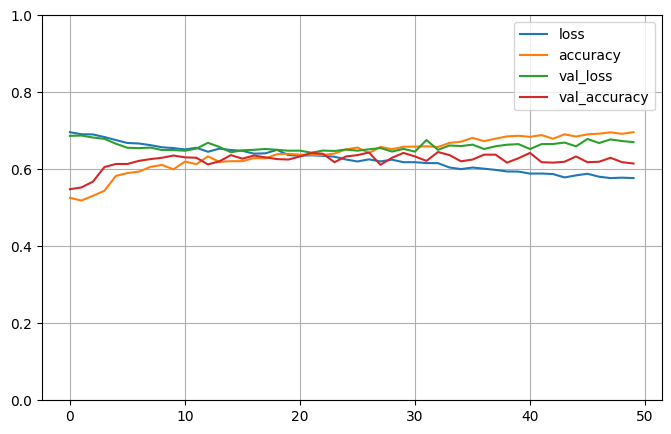


Testing # 1 1
2023-04-06 19:29:10.314151
2023-04-06 19:29:10.314490
PREDICT
2023-04-06 19:29:10.540389
Test 1:0 458:412 52.64%
Predict 1:0 555:315 63.79%
Test sizes (870, 4998) (870,)
Distrib of scores: 0.52953 mean 0.1994868 std
Range of scores: 0.017914519 to 0.85278785
Score threshold 0.5
Confusion matrix
 [[196 216]
 [119 339]]
Normalized matrix
 [[0.22528736 0.24827586]
 [0.13678161 0.38965517]]
Correct scores pos:neg 189 119
Wrong scores pos:neg 96 56


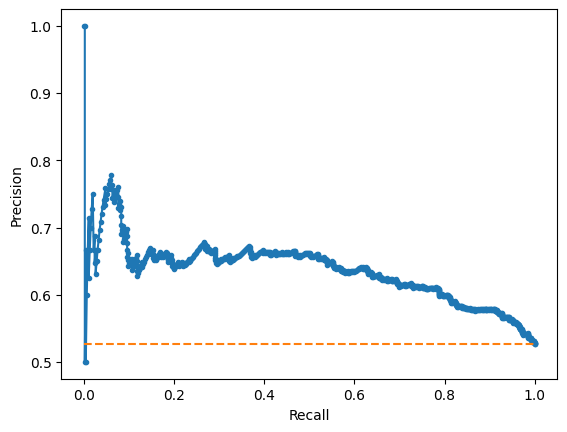

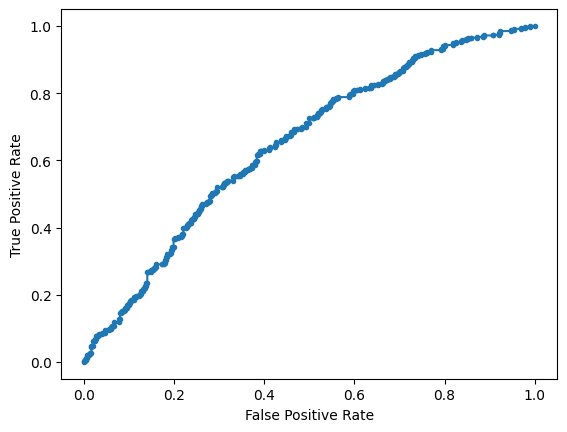

Accuracy: 61.49% Precision: 61.08% Recall: 74.02%
F1: 66.93% MCC: 0.2243
AUPRC: 63.69% AUROC: 64.75%
 accuracy [61.49425287356321]
 precision [61.08108108108108]
 recall [74.0174672489083]
 F1 [66.92991115498519]
 MCC [0.22430446007463756]
 AUPRC [63.68957888453433]
 AUROC [64.75018018399965]

Training # 1 2
2023-04-06 19:29:11.204383
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-06 19:29:11.218846
Discriminator ZERO -1
Train 1:0 1816:1669 52.11%
Valid 1:0 442:442 50.00%
FIT
2023-04-06 19:29:12.474039


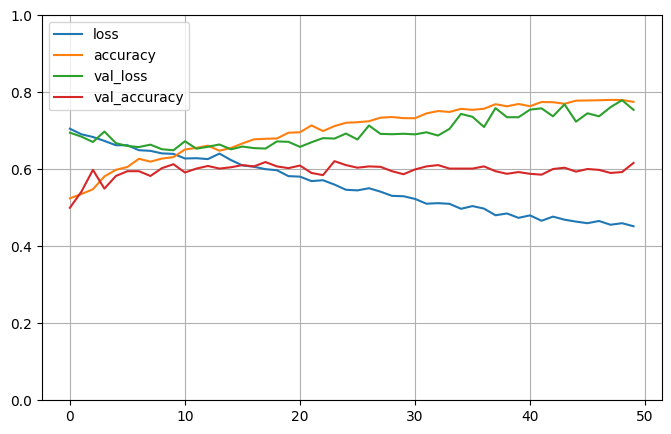


Testing # 1 2
2023-04-06 19:30:36.218251
2023-04-06 19:30:36.218290
PREDICT
2023-04-06 19:30:36.449592
Test 1:0 442:442 50.00%
Predict 1:0 519:365 58.71%
Test sizes (884, 4998) (884,)
Distrib of scores: 0.5332769 mean 0.27544436 std
Range of scores: 0.0009390595 to 0.9781472
Score threshold 0.5
Confusion matrix
 [[234 208]
 [131 311]]
Normalized matrix
 [[0.26470588 0.23529412]
 [0.14819005 0.35180995]]
Correct scores pos:neg 215 162
Wrong scores pos:neg 138 78


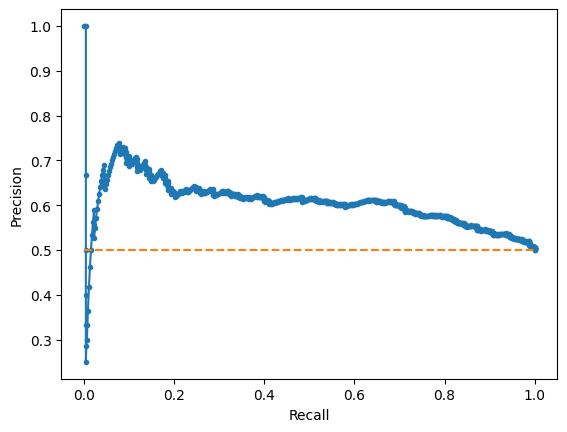

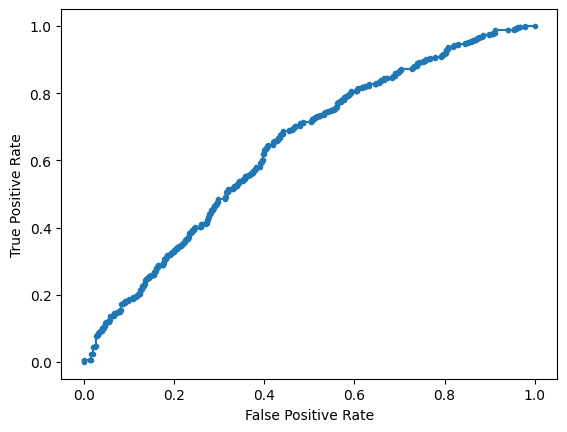

Accuracy: 61.65% Precision: 59.92% Recall: 70.36%
F1: 64.72% MCC: 0.2367
AUPRC: 60.61% AUROC: 64.00%
 accuracy [61.651583710407245]
 precision [59.92292870905588]
 recall [70.36199095022624]
 F1 [64.72424557752342]
 MCC [0.23665032953188175]
 AUPRC [60.608180027049116]
 AUROC [64.00411539485268]

Training # 1 3
2023-04-06 19:30:37.113600
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-06 19:30:37.131566
Discriminator ZERO -1
Train 1:0 1816:1704 51.59%
Valid 1:0 442:407 52.06%
FIT
2023-04-06 19:30:38.391262


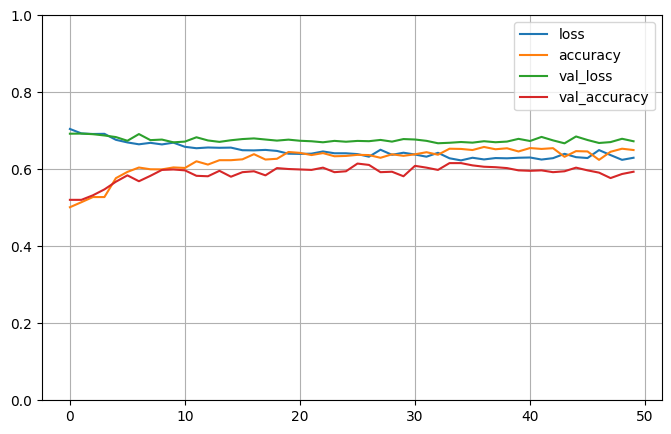


Testing # 1 3
2023-04-06 19:32:01.630012
2023-04-06 19:32:01.630057
PREDICT
2023-04-06 19:32:01.851217
Test 1:0 442:407 52.06%
Predict 1:0 467:382 55.01%
Test sizes (849, 4998) (849,)
Distrib of scores: 0.5160936 mean 0.15206318 std
Range of scores: 0.092146546 to 0.7995775
Score threshold 0.5
Confusion matrix
 [[222 185]
 [160 282]]
Normalized matrix
 [[0.2614841  0.21790342]
 [0.18845701 0.33215548]]
Correct scores pos:neg 134 83
Wrong scores pos:neg 70 39


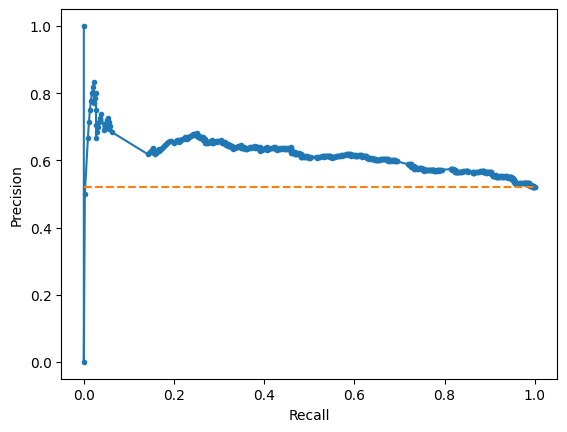

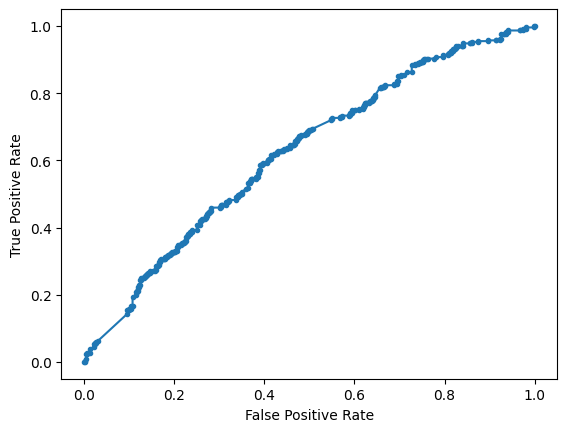

Accuracy: 59.36% Precision: 60.39% Recall: 63.80%
F1: 62.05% MCC: 0.1842
AUPRC: 61.59% AUROC: 62.24%
 accuracy [59.36395759717315]
 precision [60.38543897216274]
 recall [63.80090497737556]
 F1 [62.04620462046204]
 MCC [0.18423329411694758]
 AUPRC [61.58526733981257]
 AUROC [62.240541652306355]

Training # 1 4
2023-04-06 19:32:02.494022
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-06 19:32:02.517021
Discriminator ZERO -1
Train 1:0 1799:1680 51.71%
Valid 1:0 459:431 51.57%
FIT
2023-04-06 19:32:03.784736


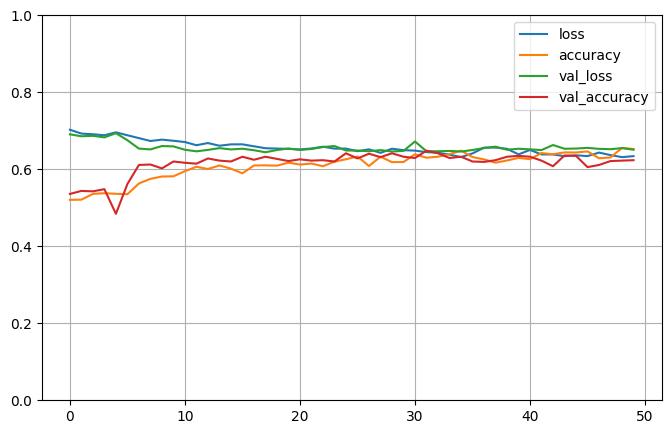


Testing # 1 4
2023-04-06 19:33:27.253098
2023-04-06 19:33:27.253135
PREDICT
2023-04-06 19:33:27.503708
Test 1:0 459:431 51.57%
Predict 1:0 432:458 48.54%
Test sizes (890, 4998) (890,)
Distrib of scores: 0.47770482 mean 0.14293504 std
Range of scores: 0.084076844 to 0.70531327
Score threshold 0.5
Confusion matrix
 [[277 154]
 [181 278]]
Normalized matrix
 [[0.31123596 0.17303371]
 [0.20337079 0.31235955]]
Correct scores pos:neg 94 131
Wrong scores pos:neg 29 59


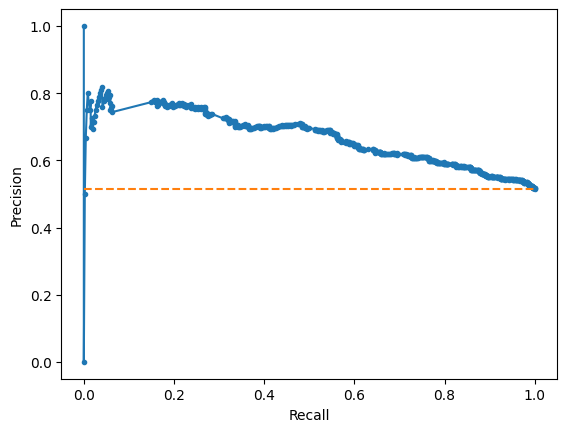

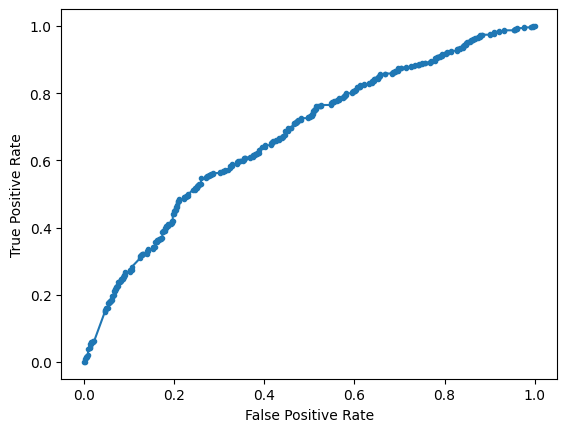

Accuracy: 62.36% Precision: 64.35% Recall: 60.57%
F1: 62.40% MCC: 0.2483
AUPRC: 66.99% AUROC: 67.42%
 accuracy [62.35955056179775]
 precision [64.35185185185185]
 recall [60.56644880174292]
 F1 [62.40179573512907]
 MCC [0.2483389570713236]
 AUPRC [66.98647258393481]
 AUROC [67.4185786714789]

Training # 1 5
2023-04-06 19:33:28.316308
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-06 19:33:28.337844
Discriminator ZERO -1
Train 1:0 1801:1692 51.56%
Valid 1:0 457:419 52.17%
FIT
2023-04-06 19:33:29.565814


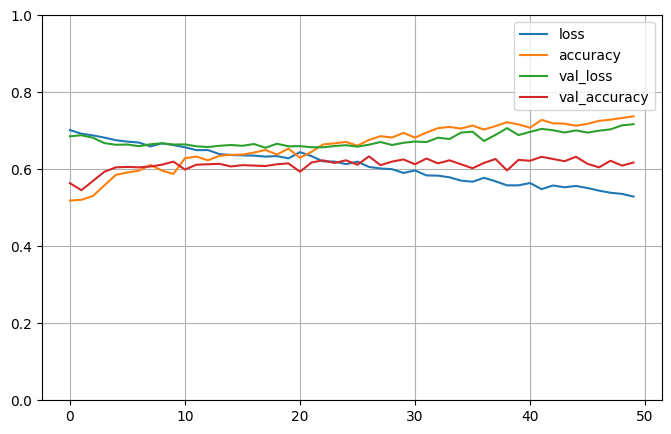


Testing # 1 5
2023-04-06 19:34:48.596107
2023-04-06 19:34:48.596149
PREDICT
2023-04-06 19:34:48.816234
Test 1:0 457:419 52.17%
Predict 1:0 530:346 60.50%
Test sizes (876, 4998) (876,)
Distrib of scores: 0.5237052 mean 0.24535394 std
Range of scores: 0.014480608 to 0.91430116
Score threshold 0.5
Confusion matrix
 [[215 204]
 [131 326]]
Normalized matrix
 [[0.24543379 0.23287671]
 [0.14954338 0.37214612]]
Correct scores pos:neg 227 158
Wrong scores pos:neg 130 88


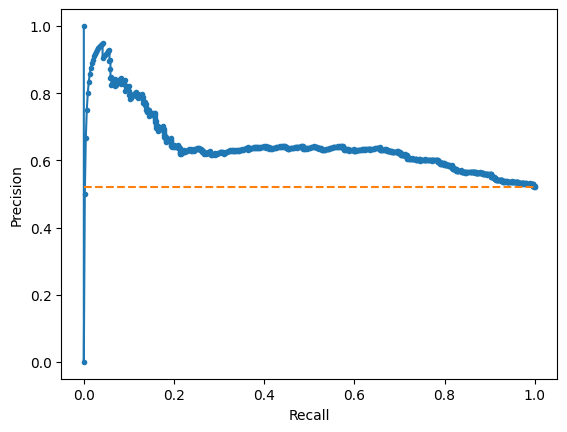

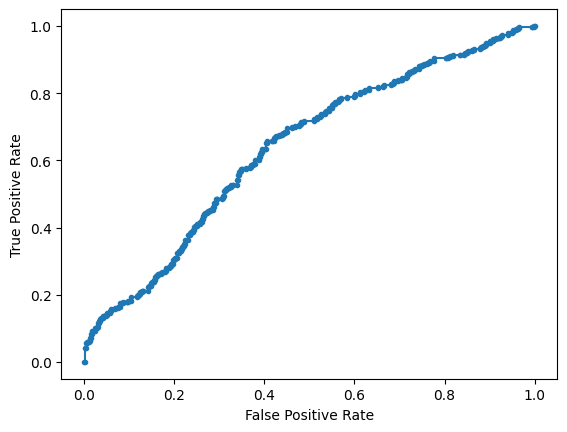

Accuracy: 61.76% Precision: 61.51% Recall: 71.33%
F1: 66.06% MCC: 0.2314
AUPRC: 64.53% AUROC: 63.66%
 accuracy [61.757990867579906]
 precision [61.50943396226415]
 recall [71.33479212253829]
 F1 [66.05876393110435]
 MCC [0.23142393284228796]
 AUPRC [64.527435309102]
 AUROC [63.6594371301891]

Training # 2 1
2023-04-06 19:34:49.448969
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-06 19:34:49.470866
Discriminator ZERO -1
Train 1:0 1786:1696 51.29%
Valid 1:0 472:415 53.21%
FIT
2023-04-06 19:34:50.738858


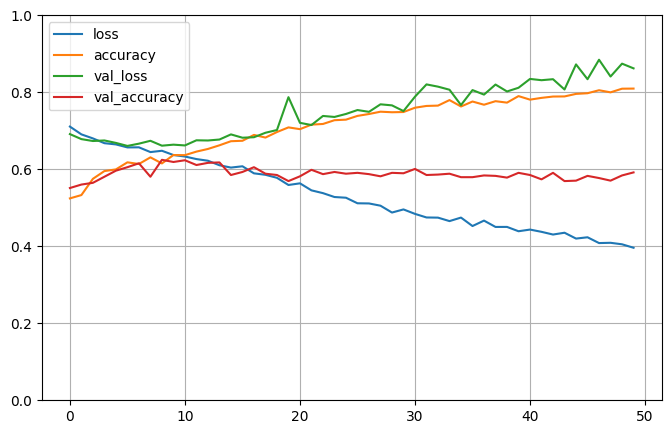


Testing # 2 1
2023-04-06 19:36:14.077003
2023-04-06 19:36:14.077057
PREDICT
2023-04-06 19:36:14.335861
Test 1:0 472:415 53.21%
Predict 1:0 644:243 72.60%
Test sizes (887, 4998) (887,)
Distrib of scores: 0.6169952 mean 0.2742129 std
Range of scores: 0.00016213699 to 0.9974632
Score threshold 0.5
Confusion matrix
 [[148 267]
 [ 95 377]]
Normalized matrix
 [[0.16685457 0.30101466]
 [0.10710259 0.42502818]]
Correct scores pos:neg 293 105
Wrong scores pos:neg 200 60


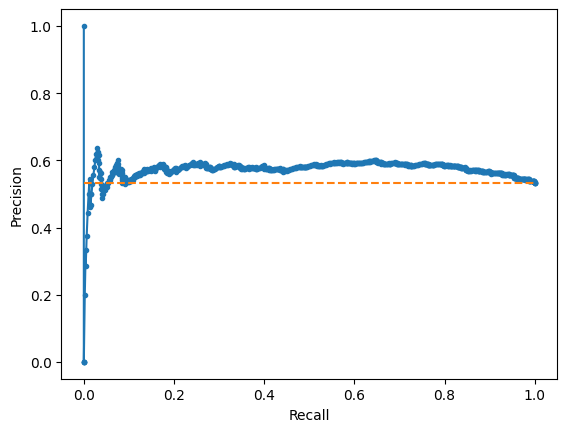

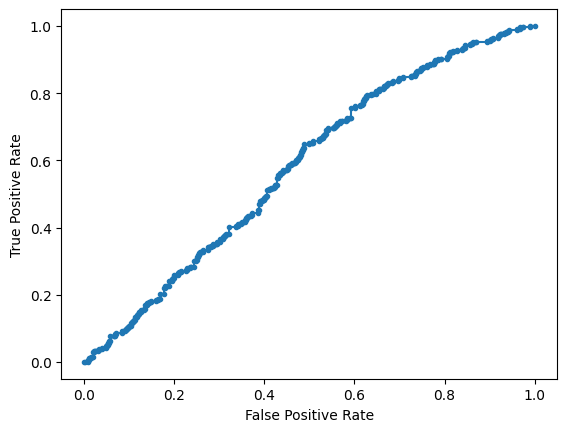

Accuracy: 59.19% Precision: 58.54% Recall: 79.87%
F1: 67.56% MCC: 0.1738
AUPRC: 57.28% AUROC: 58.19%
 accuracy [59.188275084554675]
 precision [58.54037267080745]
 recall [79.87288135593221]
 F1 [67.56272401433692]
 MCC [0.17381013860208794]
 AUPRC [57.28309333069285]
 AUROC [58.18664488462324]

Training # 2 2
2023-04-06 19:36:15.132414
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-06 19:36:15.154514
Discriminator ZERO -1
Train 1:0 1806:1695 51.59%
Valid 1:0 452:416 52.07%
FIT
2023-04-06 19:36:16.392205


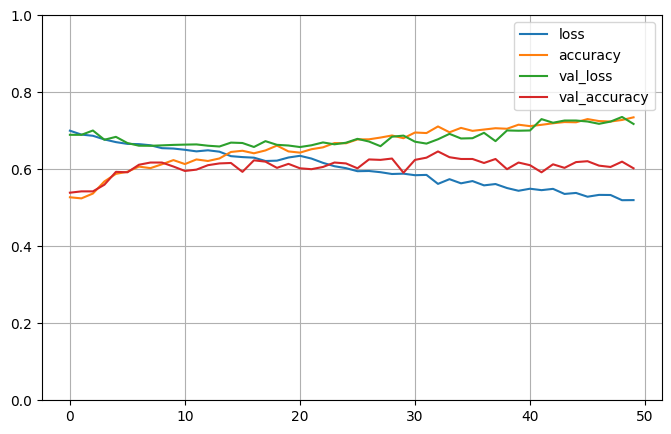


Testing # 2 2
2023-04-06 19:37:35.313844
2023-04-06 19:37:35.313885
PREDICT
2023-04-06 19:37:35.540915
Test 1:0 452:416 52.07%
Predict 1:0 549:319 63.25%
Test sizes (868, 4998) (868,)
Distrib of scores: 0.5340967 mean 0.22498457 std
Range of scores: 0.0037016352 to 0.9176119
Score threshold 0.5
Confusion matrix
 [[195 221]
 [124 328]]
Normalized matrix
 [[0.22465438 0.25460829]
 [0.14285714 0.37788018]]
Correct scores pos:neg 180 121
Wrong scores pos:neg 107 63


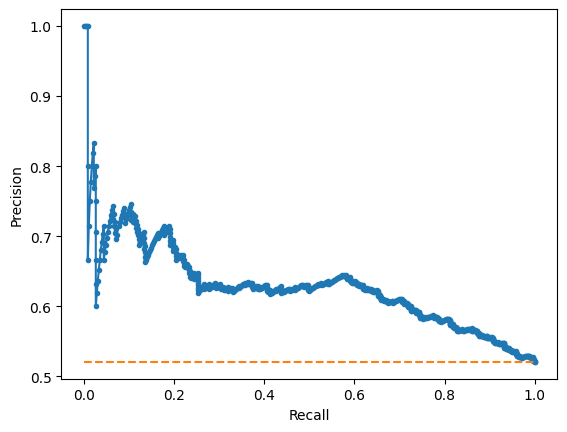

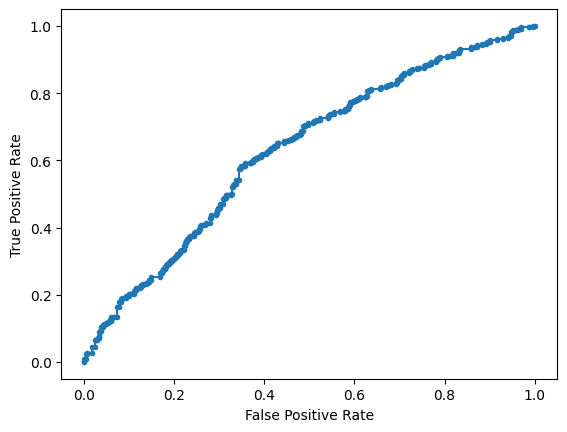

Accuracy: 60.25% Precision: 59.74% Recall: 72.57%
F1: 65.53% MCC: 0.2014
AUPRC: 62.87% AUROC: 62.93%
 accuracy [60.25345622119816]
 precision [59.74499089253188]
 recall [72.56637168141593]
 F1 [65.53446553446554]
 MCC [0.2014472170968471]
 AUPRC [62.87091868545218]
 AUROC [62.930245915588834]

Training # 2 3
2023-04-06 19:37:36.171325
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-06 19:37:36.685102
Discriminator ZERO -1
Train 1:0 1805:1704 51.44%
Valid 1:0 453:407 52.67%
FIT
2023-04-06 19:37:38.889033


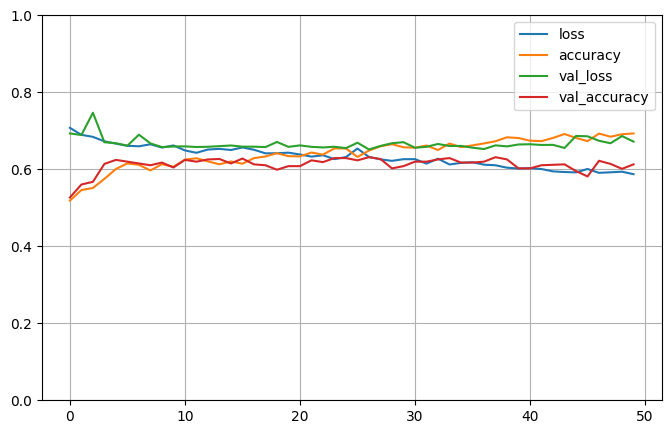


Testing # 2 3
2023-04-06 19:39:02.491250
2023-04-06 19:39:02.491291
PREDICT
2023-04-06 19:39:02.723265
Test 1:0 453:407 52.67%
Predict 1:0 606:254 70.47%
Test sizes (860, 4998) (860,)
Distrib of scores: 0.5695536 mean 0.19155294 std
Range of scores: 0.019560326 to 0.8613698
Score threshold 0.5
Confusion matrix
 [[164 243]
 [ 90 363]]
Normalized matrix
 [[0.19069767 0.28255814]
 [0.10465116 0.42209302]]
Correct scores pos:neg 240 87
Wrong scores pos:neg 141 44


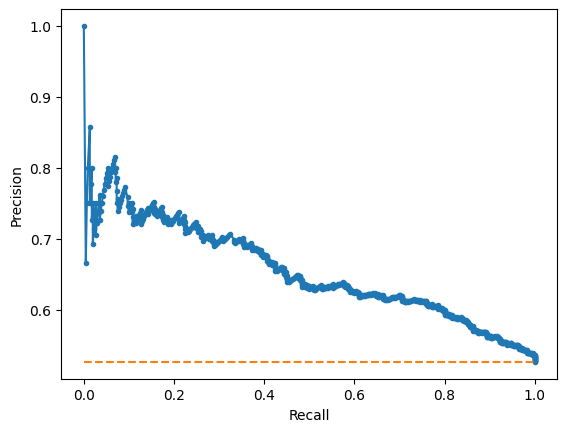

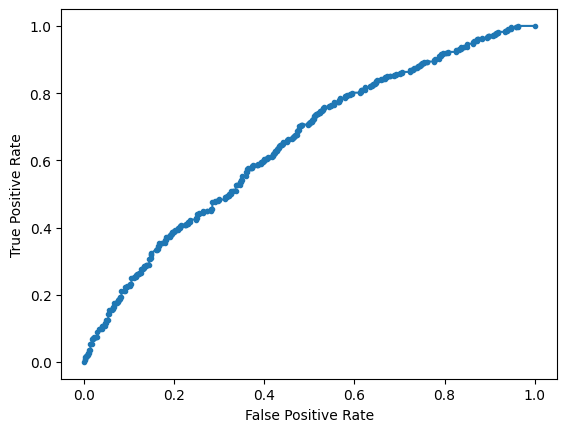

Accuracy: 61.28% Precision: 59.90% Recall: 80.13%
F1: 68.56% MCC: 0.2236
AUPRC: 65.52% AUROC: 64.81%
 accuracy [61.27906976744186]
 precision [59.900990099009896]
 recall [80.13245033112582]
 F1 [68.55524079320114]
 MCC [0.22356504583285466]
 AUPRC [65.52493102045752]
 AUROC [64.81306713094793]

Training # 2 4
2023-04-06 19:39:03.537182
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-06 19:39:03.784993
Discriminator ZERO -1
Train 1:0 1826:1664 52.32%
Valid 1:0 432:447 49.15%
FIT
2023-04-06 19:39:05.016733


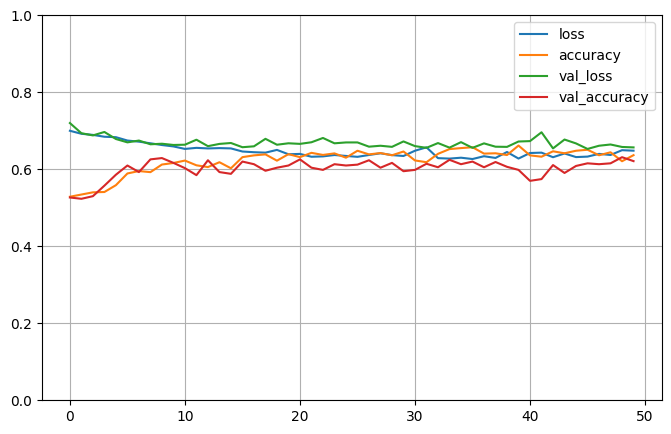


Testing # 2 4
2023-04-06 19:40:28.344603
2023-04-06 19:40:28.344644
PREDICT
2023-04-06 19:40:28.588110
Test 1:0 432:447 49.15%
Predict 1:0 527:352 59.95%
Test sizes (879, 4998) (879,)
Distrib of scores: 0.5186807 mean 0.13946234 std
Range of scores: 0.18226753 to 0.7416649
Score threshold 0.5
Confusion matrix
 [[233 214]
 [119 313]]
Normalized matrix
 [[0.26507395 0.24345848]
 [0.13538111 0.35608646]]
Correct scores pos:neg 114 93
Wrong scores pos:neg 68 37


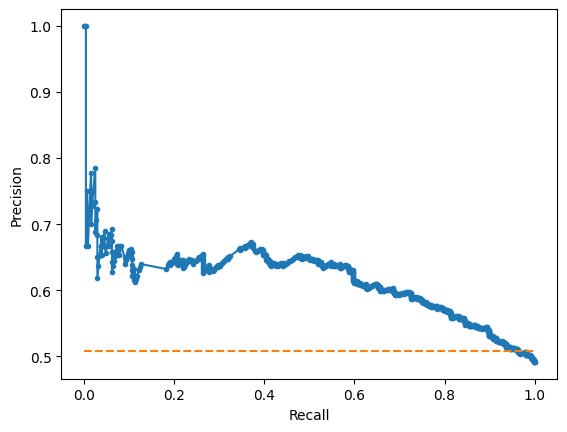

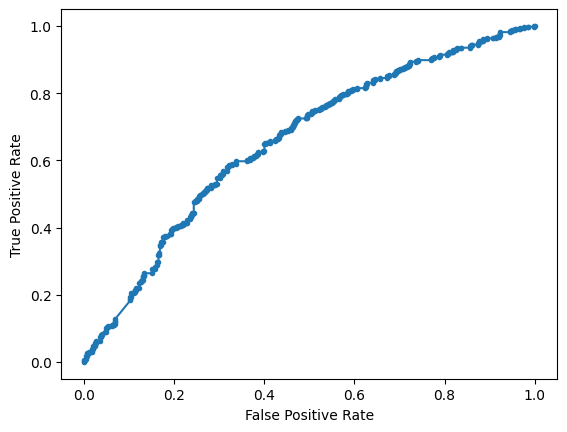

Accuracy: 62.12% Precision: 59.39% Recall: 72.45%
F1: 65.28% MCC: 0.2508
AUPRC: 61.61% AUROC: 65.66%
 accuracy [62.116040955631405]
 precision [59.39278937381404]
 recall [72.45370370370371]
 F1 [65.27632950990615]
 MCC [0.25077423308888996]
 AUPRC [61.614621290714]
 AUROC [65.66280346341867]

Training # 2 5
2023-04-06 19:40:29.379111
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-06 19:40:29.746316
Discriminator ZERO -1
Train 1:0 1809:1685 51.77%
Valid 1:0 449:426 51.31%
FIT
2023-04-06 19:40:31.956506


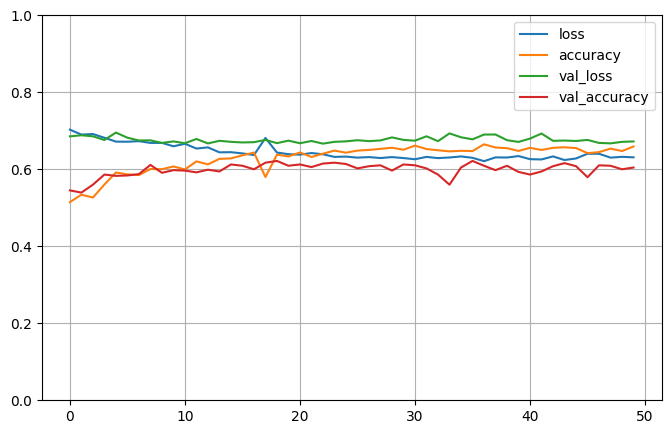


Testing # 2 5
2023-04-06 19:41:55.366271
2023-04-06 19:41:55.366305
PREDICT
2023-04-06 19:41:55.608875
Test 1:0 449:426 51.31%
Predict 1:0 609:266 69.60%
Test sizes (875, 4998) (875,)
Distrib of scores: 0.57711494 mean 0.16503663 std
Range of scores: 0.15859875 to 0.7747245
Score threshold 0.5
Confusion matrix
 [[173 253]
 [ 93 356]]
Normalized matrix
 [[0.19771429 0.28914286]
 [0.10628571 0.40685714]]
Correct scores pos:neg 252 90
Wrong scores pos:neg 155 32


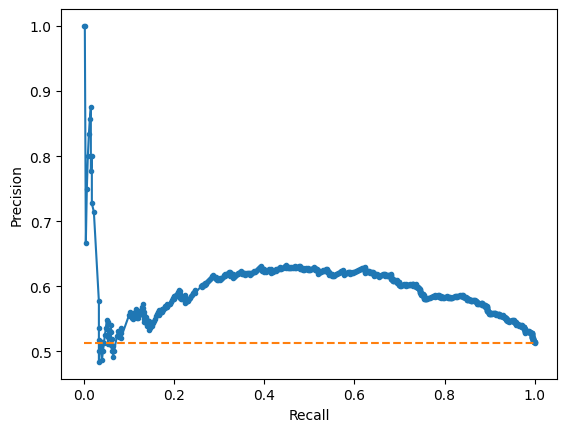

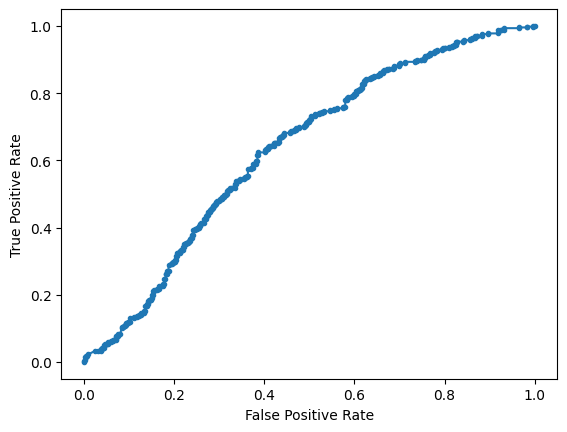

Accuracy: 60.46% Precision: 58.46% Recall: 79.29%
F1: 67.30% MCC: 0.2162
AUPRC: 59.56% AUROC: 63.28%
 accuracy [60.457142857142856]
 precision [58.45648604269294]
 recall [79.28730512249443]
 F1 [67.29678638941398]
 MCC [0.21621207180491214]
 AUPRC [59.56029295334759]
 AUROC [63.28225477587126]
2023-04-06 19:41:56.264214


In [77]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
# allids,allseq = loader.load_spectra(filepath)  # for MLP
allids,allseq = loader.load_sequence(filepath)  # for CNN and RNN
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)
           
        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [78]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.99% std 1.12
 precision mean 60.33% std 1.71
 recall mean 72.44% std 6.54
 F1 mean 65.64% std 2.14
 MCC mean 0.2191 std 0.0257
 AUPRC mean 62.43% std 2.90
 AUROC mean 63.69% std 2.44
 accuracy [[61.49425287356321], [61.651583710407245], [59.36395759717315], [62.35955056179775], [61.757990867579906], [59.188275084554675], [60.25345622119816], [61.27906976744186], [62.116040955631405], [60.457142857142856]]
 precision [[61.08108108108108], [59.92292870905588], [60.38543897216274], [64.35185185185185], [61.50943396226415], [58.54037267080745], [59.74499089253188], [59.900990099009896], [59.39278937381404], [58.45648604269294]]
 recall [[74.0174672489083], [70.36199095022624], [63.80090497737556], [60.56644880174292], [71.33479212253829], [79.87288135593221], [72.56637168141593], [80.13245033112582], [72.45370370370371], [79.28730512249443]]
 F1 [[66.92991115498519], [64.72424557752342], [62.04620462046204], [62.40179573512907], [66.05876393110435], [67.56272401433692], [